## Get Started Adversarial Defenses

__Description__:

This notebook demonstrates how to deploy defenses using HEART and MAITE

__Intended Audience__:

All T&E Users

## Contents:
1. Notebook imports
2. Load the data and model
3. Defending white-box attacks
4. Defending black-box attacks
5. Post-processing defense
6. Detection defence
7. Transformer defence
8. Adversarial training
9. Object detection task defence 
10. Conclusions and next steps

## 1. Notebook imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from datasets import load_dataset

from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.attacks.attack import JaticAttack
from art.attacks.evasion import ProjectedGradientDescentPyTorch

%matplotlib inline

## 2. Load the dataset and model
In this notebook demonstration, we are focussing on the image-classification task:
- First load an applicable dataset for classification. In this notebook we load the XView dataset for classification
- Then load a classification model. In this notebook we select a resnet18 which has been trained on XView data

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

'''
Load an applicable dataset
'''
data = load_dataset("CDAO/xview-subset-classification", split="test[0:14]")

'''
Define the model
'''
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
)

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 3. Defending white-box attacks
The following cell demonstrates the standard method of deploying a white-box attack, PGD, using HEART.

Note the results from this attack. When considering deploying a defense, we need to consider:
- does the application of defense negatively impact the clean accuracy?
- does the application of defense adequately positively impact robust accuracy?

In [3]:
'''
Define and wrap the attacks
'''
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack_undefended(data=data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (undefended): {results["clean_accuracy"]}\nrobust accuracy (undefended): {results["robust_accuracy"]}')

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

clean accuracy (undefended): 0.7857142857142857
robust accuracy (undefended): 0.35714285714285715


#### JPEG Compression

The following cell defines a __preprocessing__ algorithm, JPEG compression, and applies it to the MAITE compatible estimator as a defense. Using the adversarial samples generated in the previous cell, we can assess the clean and robust accuracy of the defended model.

Here we compare the clean accuracy with the clean accuracy of the undefended model (previous cell) to determine whether or not the defense negatively impacts the model in scenarios where no attack is launched against it i.e. a normal operating environment. 

Next we compare the robust accuracy with the robust accuracy of the undefended model (previous cell) to determine whether or not the defense improved the model performance under attack.

Finally, we can also compare the robust accuracy with the clean accuracy of the undefended model (previous cell) to determine whether or not the defense adequately recovered perfomance.

__Tip__: play with the quality parameter of the _JpegCompression_, this determines how much to modify the image during preprocessing. A quality of 95 will make little changes to the image, but at the risk of providing very little defense, while a quality of 1 will make larger changes to the image during preprocessing, but at the risk of decreasing the performance of clean accuracy. In this instance, when the quality is set to 1, the clean accuracy decreases from 0.75 and when the quality is set to 95 the robust accuracy decreases. 

In [4]:
from art.defences.preprocessor import JpegCompression
'''
Define the method of defense
'''
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=95
                                        )
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1), 
    preprocessing_defences=[preprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.7857142857142857
robust accuracy (defended): 0.5


#### Spatial Smoothing

The following cell demonstrates a different preprocessing defense applied to a MAITE compatible classifier but the method of application remains consistent with the previous cell.

The following preprocessing defense requires ```pip install kornia```

```python
from art.defences.preprocessor import SpatialSmoothingPyTorch
'''
Define the method of defense
'''
preprocessing_defense = SpatialSmoothingPyTorch(window_size=5, 
                                                clip_values=(0,1),
                                                channels_first=True,
                                                apply_predict=True
                                                )
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1), 
    preprocessing_defences=[preprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric()
metric.update(jptc_defended, data, x_adv)
clean_acc, robust_acc, _ = metric.compute()

print(f'clean accuracy (defended): {clean_acc}\nrobust accuracy (defended): {robust_acc}')
```

#### Variance minimization
The following cell demonstrates a different preprocessing defense applied to a MAITE compatible classifier but the method of application remains consistent with the previous cell.

__Note__: this defense has fully recovered the accuracy when under attack, whilst the other defenses did not - multiple types of defense should be evaluated to determine which fits best for each problem


In [5]:
from art.defences.preprocessor import TotalVarMin

preprocessing_defense = TotalVarMin(clip_values=(0,1), max_iter=20)
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
    preprocessing_defences=[preprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.7857142857142857
robust accuracy (defended): 0.7857142857142857


## 4. Defending black-box attacks

The following cell demonstrates a typical black-box attack with HEART and compatible with MAITE

In [6]:
from heart_library.attacks.attack import JaticAttack
from art.attacks.evasion import HopSkipJump

'''
Define and wrap the attacks
'''
evasion_attack_undefended = HopSkipJump(classifier=jptc, max_iter=1)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack_undefended(data=data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc(data), metadata)
metric.update(jptc(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

HopSkipJump:   0%|          | 0/14 [00:00<?, ?it/s]

clean accuracy (defended): 0.7857142857142857
robust accuracy (defended): 0.42857142857142855


#### Variance minimization
The following cell demonstrates the defense effective at recovering model performance against white-box attacks, now applied to black-box adversarial samples. 

__Note__: in this instance the robust defense did not fully recover the clean accuracy as per the white-box attack.

In [7]:
from art.defences.preprocessor import TotalVarMin

preprocessing_defense = TotalVarMin(clip_values=(0,1), max_iter=20)
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
    preprocessing_defences=[preprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.7857142857142857
robust accuracy (defended): 0.5714285714285714


## 5. Post-processing defense
The previous cells have demonstrated preprocessing defenses. This is but one type of defense - another type of defense are post-processing defenses, which apply post-processing to the predictions output by the model. 

Implementing post-processing defenses within HEART, to be compliant with MAITE, is similar to that of the pre-processing defenses. A postprocessing defense is first defined, then added as a parameter, ```postprocessing_defenses```, within the ```MAITE``` compliant ```JaticPyTorchClassifier```

#### High Confidence

__Note__: whilst this post-processing defense hasn't recovered clean accuracy performance, it has improved the robust accuracy from an undefended model

In [8]:
from art.defences.postprocessor import HighConfidence

postprocessing_defense = HighConfidence(cutoff=0.1)
'''
Apply the preprocessing defense to the estimator
'''
jptc_defended = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
    postprocessing_defences=[postprocessing_defense]
)

'''
Calc clean and robust accuracy
'''
metric.update(jptc_defended(x_adv), y)
results= metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

clean accuracy (defended): 0.7857142857142857
robust accuracy (defended): 0.42857142857142855


## 6. Detector defence

(Work in Progress)

This family of defences attempts to detect adversarial samples

__Note__: in the example below, if adversarial samples are detected, they are not passed for evaluation. If all adversarial images are detected, a robust accuracy of 1 is displayed.

In [10]:
from heart_library.utils import process_inputs_for_art
from art.defences.detector.evasion import BinaryInputDetector
from art.estimators.classification import PyTorchClassifier

'''
Sample basic classifier to act as detector
'''
def get_simple_classifier():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 16x224x224
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2), # 16x112x112
        torch.nn.Flatten(),
        torch.nn.Linear(16*112*112, 2), # 2 classes (binary classification)
    )
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    classifier = PyTorchClassifier(
        model,
        loss=criterion,
        optimizer=optimizer,
        input_shape=(3, 224, 224),
        nb_classes=2,
    )
    return classifier

'''
Define and wrap the attacks
'''
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=5, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack_undefended(data=data)

# Compile training data for detector:
x_train, _, _ = process_inputs_for_art(data)
x_train_detector = np.concatenate((x_train, x_adv[0]), axis=0)
y_train_detector = np.concatenate((np.array([[1, 0]] * len(x_train)), np.array([[0, 1]] * len(x_adv[0]))), axis=0)

# Create a simple CNN for the detector
detector_classifier = get_simple_classifier()

detector = BinaryInputDetector(detector_classifier)
detector.fit(x_train_detector, y_train_detector, nb_epochs=200, batch_size=128)

# Apply detector on clean and adversarial test data:
_, test_detection = detector.detect(x_train)
_, test_adv_detection = detector.detect(x_adv[0])

print('Percentage of benign samples detected as adversarial:', test_detection.mean())
print('Percentage of adversarial samples detected as adversarial:', test_adv_detection.mean())

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Percentage of benign samples detected as adversarial: 0.21428571428571427
Percentage of adversarial samples detected as adversarial: 0.5


## 7. Transformer defence

#### Defensive Distillation 

(Work in Progress)

Demonstration of a tranformer type defence against PGD attack.

__Note__: This attack shown to improve the robust accuracy slightly and also postively impact the clean accuracy.

In [11]:
from copy import deepcopy
from art.defences.transformer.evasion import DefensiveDistillation
from heart_library.utils import process_inputs_for_art

'''
Define the model, adding a Softmax layer as this defence must have probability outputs
'''
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
model.fc = torch.nn.Sequential(
    model.fc,
    torch.nn.Softmax()
)
_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
jptc_defended = JaticPyTorchClassifier(
    model=deepcopy(model), loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1), optimizer=optimizer,
)

# Create defensive distillation transformer
transformer = DefensiveDistillation(classifier=jptc)

x_train, _, _ = process_inputs_for_art(data)
jptc_defended = transformer(x=x_train, transformed_classifier=jptc_defended)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(jptc_defended(data), metadata)
metric.update(jptc_defended(x_adv), y)
results = metric.compute()

print(f'clean accuracy (defended): {results["clean_accuracy"]}\nrobust accuracy (defended): {results["robust_accuracy"]}')

/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


clean accuracy (defended): 0.8571428571428571
robust accuracy (defended): 0.35714285714285715


## 8. Adversarial training 

(Work in Progress)

The following cell demonstrates how to execute adversarial training using HEART's MATIE compliant classifier.

In [12]:
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
from heart_library.utils import process_inputs_for_art
from torch.optim import Adam
'''
Define the model
'''
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../utils/resources/models/xview_model.pt'))
_ = model.eval()

'''
Wrap the model
'''
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
robust_jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1),
    optimizer=optimizer
)
x_train, y_train, _ = process_inputs_for_art(data)
robust_jptc.fit(x_train, y_train, nb_epochs=50)

'''
Define and wrap the attacks
'''
evasion_attack_undefended = ProjectedGradientDescentPyTorch(estimator=robust_jptc, max_iter=10, eps=0.03)
attack_undefended = JaticAttack(evasion_attack_undefended, norm=2)

'''
Generate adversarial images
'''
x_adv, y, metadata = attack_undefended(data=data)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(robust_jptc(data), metadata)
metric.update(robust_jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (undefended): {results["clean_accuracy"]}\nrobust accuracy (undefended): {results["robust_accuracy"]}')

attacks = ProjectedGradientDescent(robust_jptc, eps=0.3, eps_step=0.01, max_iter=10)
trainer = AdversarialTrainer(robust_jptc, attacks, ratio=1.0)
trainer.fit(x_train, np.array(y_train), nb_epochs=5, batch_size=128)

'''
Calc clean and robust accuracy
'''
metric = AccuracyPerturbationMetric(robust_jptc(data), metadata)
metric.update(robust_jptc(x_adv), y)
results = metric.compute()

print(f'clean accuracy (undefended): {results["clean_accuracy"]}\nrobust accuracy (undefended): {results["robust_accuracy"]}')

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

clean accuracy (undefended): 1.0
robust accuracy (undefended): 0.14285714285714285


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

clean accuracy (undefended): 0.42857142857142855
robust accuracy (undefended): 0.42857142857142855


## 9. Object detection task defences
The following section demonstrates defenses applied to the object detection task. The application of defenses remains consistent with the classification task demonstrated above.

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main


Resolving data files:   0%|          | 0/202 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

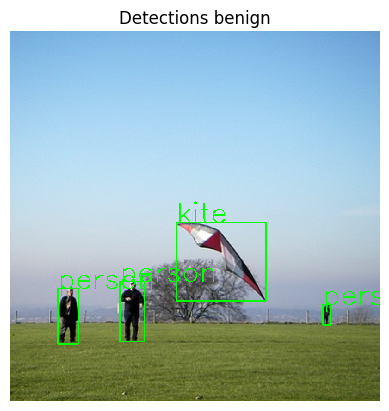

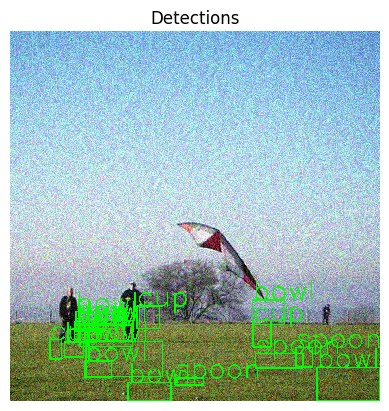

In [14]:
import numpy as np
from torchvision.transforms import transforms
from heart_library.estimators.object_detection import JaticPyTorchDETR
from art.attacks.evasion import ProjectedGradientDescent
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

coco_labels = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [coco_labels[i] for i in list(predictions_.labels)]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_.boxes)]

    # Get the predicted prediction score
    predictions_score = list(predictions_.scores)
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    img = (img*255).astype(np.uint8)
    text_size = 2
    text_th = 2
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, interpolation="nearest")
    # plt.show()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
NUMBER_CHANNELS = 3
INPUT_SHAPE = (NUMBER_CHANNELS, 800, 800)

'''
Define the detector
'''
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 
preprocessing=(MEAN, STD)

detector = JaticPyTorchDETR(device_type='cpu',
                            input_shape=(3, 800, 800),
                            clip_values=(0, 1), 
                            attack_losses=( "loss_ce",
                                "loss_bbox",
                                "loss_giou",), 
                            preprocessing=(MEAN, STD))

'''
Prepare COCO image data
'''
from datasets import load_dataset
import torch

data = load_dataset("guydada/quickstart-coco", split="train[20:30]")

preprocess = transforms.Compose([
    transforms.Resize(800),
    transforms.CenterCrop(800),
    transforms.ToTensor()
])

data = data.map(lambda x: {"image": preprocess(x["image"]), "label": None})

from typing import Tuple, Dict, Any, Sequence

class ImageDataset:
    def __init__(self, images, groundtruth, threshold=0.5):
        self.images = images
        self.groundtruth = groundtruth
        self.threshold = threshold
        
    def __len__(self)->int:
        return len(self.data)
    
    def __getitem__(self, ind: int) -> Tuple[np.ndarray, np.ndarray, Sequence[Dict[str, Any]]]:
        image = self.images.__getitem__(ind)["image"]
        filtered_detection = self.groundtruth[ind]
        
        filtered_detection.boxes = filtered_detection.boxes[filtered_detection.scores>self.threshold]
        filtered_detection.labels = filtered_detection.labels[filtered_detection.scores>self.threshold]
        filtered_detection.scores = filtered_detection.scores[filtered_detection.scores>self.threshold]
        
        return (image, filtered_detection, [])

'''
Detect objects
'''
detections = detector(data)

data_with_gt = ImageDataset(data, detections)
sample_data = torch.utils.data.Subset(data_with_gt, list(range(1)))

'''
View the detections
'''
for i in range(len(sample_data)):
    preds_orig = extract_predictions(detections[i], 0.5)
    img = np.asarray(sample_data.__getitem__(i)[0]).transpose(1,2,0)
    plot_image_with_boxes(img=img.copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections benign")
    
'''
Deploy an attack
'''
attack = JaticAttack(ProjectedGradientDescent(detector, max_iter=100, eps_step=0.01, eps=0.2, targeted=False), norm=2)
adv_images, y, metadata = attack(sample_data)

'''
View detections on adversarial images
'''
adv_detections = detector(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.95)
    plot_image_with_boxes(img=adv_images[0][i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

#### JPEG Compression 
The following cell demonstrates the application of the JPEG Compression defence to harden the MAITE compliant HEART detector and illustrates the detections using the defended detector and adversarial samples generated previously.

__Note__: Whilst the defended detector performs better over the undefended detector, it does not fully recover. Note how one of the remotes still evades detection. However, spurious detections (such as cup) are no longer present and the bounding boxes are accurate once again within the selected threshold.

Using cache found in /Users/kieranfraser/.cache/torch/hub/facebookresearch_detr_main
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kieranfraser/git/work/cdao/gitlab/hardened-extension-adversarial-robustness-toolbox/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


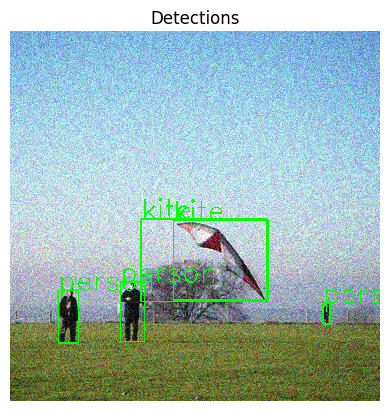

In [16]:

'''from art.defences.preprocessor import SpatialSmoothingPyTorch
preprocessing_defense = SpatialSmoothingPyTorch(window_size=7, 
                                                clip_values=(0,1),
                                                channels_first=True,
                                                apply_predict=True
                                                )'''

from art.defences.preprocessor import JpegCompression
preprocessing_defense = JpegCompression(clip_values=(0,1),
                                        channels_first=True,
                                        apply_predict=True,
                                        quality=90
                                        )

detector_defended = JaticPyTorchDETR(device_type='cpu',
                            input_shape=(3, 800, 800),
                            clip_values=(0, 1), 
                            attack_losses=( "loss_ce",
                                "loss_bbox",
                                "loss_giou",), 
                            preprocessing=(MEAN, STD),
                            preprocessing_defences=[preprocessing_defense])

'''
View detections on adversarial images
'''
adv_detections = detector_defended(adv_images)
for i in range(len(adv_detections)): 
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=adv_images[0][i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")

The following cell demonstrations the limitations of the defence shown to be effective above. In this instance, a PGD attack was deployed against the _defended detector_ which included the JPEG Compression preprocessing defence. Adversarial samples generated are effective against the defended detector❗❗

__This highlights the importance of being aware of the limitations of the defences applied to models.__

```python
'''
Deploy an attack
'''
attack = JaticAttack(ProjectedGradientDescent(detector_defended, max_iter=1, eps_step=0.01, eps=0.2))
adv_images, _, _ = attack(sample_data)

'''
View detections on adversarial images
'''
adv_detections = detector_defended(adv_images)
for i in range(len(adv_detections)):
    preds_orig = extract_predictions(adv_detections[i], 0.5)
    plot_image_with_boxes(img=adv_images[i].transpose(1,2,0).copy(),
                          boxes=preds_orig[1], pred_cls=preds_orig[0], title="Detections")
```

## 10. Conclusions and next steps
- This notebook demonstrated a variety of defenses applied to both black-box and white-box attacks on a classification model
- Modify this notebook by swapping in your own dataset and classification model
- Try out additional defenses from ART to better evaluate available mitigation approaches
- Ascertain which thresholds for clean and robust accuracy suit your task - there may be a trade-off between adding a defense to remain protected and achieving a high clean accuracy score
- Determine how expensive (computation, time, cost, performance) some defenses are over others e.g. preprocessing vs adversarial training
- Consolidate all findings into a model card for reporting